# Allen Cahn

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/physics_driven/mindspore_burgers1D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/physics_driven/mindspore_burgers1D.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/burgers1D.ipynb)

## Environment Setup

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.data_sink*. Please check [MindSpore Installation](https://www.mindspore.cn/install/en) for details.

In addition, **MindFlow version >=0.1.0** is also required. If it has not been installed in your environment, please select the right version and hardware, then install it as follows.

In [ ]:
mindflow_version = "0.1.0"  # update if needed
# GPU Comment out the following code if you are using NPU.
!pip uninstall -y mindflow-gpu
!pip install mindflow-gpu==$mindflow_version

# NPU Uncomment if needed.
# !pip uninstall -y mindflow-ascend
# !pip install mindflow-ascend==$mindflow_version

## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

In recent years, while the development of classical theories and numerical methods with computer performance tends to be smooth, machine learning methods combine a large amount of data with neural networks realize the flow field's fast simulation. These methods can obtain the accuracy close to the traditional methods, which provides a new idea for flow field solution.

The Allen-Cahn euqation (after John W. Cahn and Sam Allen) is a reaction-diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems including order-disorder transitions. The equation describes the time evolution of a scalar-valued state variable $\eta$ on a domain $\Omega$ during a time interval $T$. In this case, MindFLow fluid simulation suite is used to solve the Allen Cahn's equation based on the physical-driven PINNs (Physics INformed Neural Networks) method.

## Problem Description

The form of Allen Cahn' equation is as follows:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2u}{\partial x^2} + 5(u - u^3), \quad x \in [-1, 1], \quad t \in [0, 1]
$$

In this case, the Dirichlet boundary condition and the initial condition of the sine function are used. The format is as follows:

$$
u(-1, t) = u(1, t) = -1
$$

$$
u(x, 0) = x^2\cos(\pi x)
$$

In this case, the PINNs method is used to learn the mapping $(x, t) \mapsto u$ from position and time to corresponding physical quantities. So that the solution of Allen Cahn' equation is realized.

## Technology Path

MindFlow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. Allen Cahn.
5. Model Training.
6. Model Evaluation and Visualization.

In [1]:

import time

import numpy as np

import mindspore
from mindspore import context, nn, ops, Tensor, jit, set_seed
from mindspore import dtype as mstype
from mindspore import load_checkpoint, load_param_into_net
from mindflow.pde import PDEWithLoss
from sympy import diff, symbols, Function

from mindflow.loss import get_loss_metric

The following `src` package can be downloaded in [src](./src/)

In [2]:
from mindflow.pde import sympy_to_mindspore
from src import MultiScaleFCSequentialOutputTransform
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, visual, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

In [4]:
# load configuration
config = load_yaml_config('./configs/allen_cahn_cfg.yaml')

## Training Dataset Construction

In this case, random sampling is performed according to the solution domain, initial condition and boundary value condition to generate training data sets. The specific settings are as follows:

Download the test dataset: [physics_driven/allen_cahn/dataset].

In [5]:
# create training dataset
ac_train_dataset = create_training_dataset(config)
train_dataset = ac_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                shuffle=True,
                                                prebatched_data=True,
                                                drop_remainder=True)
# create test dataset
inputs, label = create_test_dataset(config["test_dataset_path"])

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [ ]:
# define models and optimizers
model = MultiScaleFCSequentialOutputTransform(in_channels=config["model"]["in_channels"],
                                              out_channels=config["model"]["out_channels"],
                                              layers=config["model"]["layers"],
                                              neurons=config["model"]["neurons"],
                                              residual=config["model"]["residual"],
                                              act=config["model"]["activation"],
                                              num_scales=1)
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)

## Optimizer

In [7]:
# define optimizer
optimizer = nn.Adam(model.trainable_params(),
                    config["optimizer"]["initial_lr"])

## Allen Cahn

The following `AllenCahn` defines the allen cahn' problem. Specifically, it includes 1 parts: governing equation.


In [8]:
class AllenCahn(PDEWithLoss):
    r"""
    Allen Cahn problem based on PDEWithLoss

    Args:
        model (Cell): network for training.
        loss_fn (str): Define the loss function. Default: mse.

    Supported Platforms:
        ``Ascend`` ``GPU``

    """

    def __init__(self, model, loss_fn="mse"):
        self.x, self.t = symbols("x t")
        self.u = Function("u")(self.x, self.t)
        self.in_vars = [self.x, self.t]
        self.out_vars = [self.u]
        if isinstance(loss_fn, str):
            self.loss_fn = get_loss_metric(loss_fn)
        else:
            self.loss_fn = loss_fn
        self.pde_nodes = sympy_to_mindspore(
            self.pde(), self.in_vars, self.out_vars)
        model.set_output_transform(self.output_transform)
        super(AllenCahn, self).__init__(model, self.in_vars, self.out_vars)

    def output_transform(self, x, out):
        """
        Define output transforma function in Allen Cahn Equation

        Args:
            x (Tensor): network input
            out (Tensor): network output
        """

        return x[:, 0:1] ** 2 * ops.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1] ** 2) * out

    def force_function(self, u):
        """
        Define forcing function in Allen Cahn Equation

        Args:
            u (Tensor)
        """
        return 5 * (u - u ** 3)

    def pde(self):
        """
        Define Allen Cahn equation
        """

        d = 0.001
        loss_1 = (
            self.u.diff(self.t)
            - d * diff(self.u, (self.x, 2))
            - self.force_function(self.u)
        )
        return {"loss_1": loss_1}

    def get_loss(self, pde_data):
        """
        Compute loss of 3 parts: governing equation, initial condition and boundary conditions.

        Args:
            pde_data (Tensor): the input data of governing equations.
            ic_data (Tensor): the input data of initial condition.
            bc_data (Tensor): the input data of boundary condition.
        """
        pde_res = ops.Concat(1)(self.parse_node(
            self.pde_nodes, inputs=pde_data))
        pde_loss = self.loss_fn(
            pde_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        return pde_loss

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [9]:
def train():
    '''Train and evaluate the network'''
    problem = AllenCahn(model)

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O2')
    else:
        loss_scaler = None

    # the loss function receives 1 data sources: pde
    def forward_fn(pde_data):
        loss = problem.get_loss(pde_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)

        return loss

    grad_fn = ops.value_and_grad(
        forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data):
        loss, grads = grad_fn(pde_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            is_finite = all_finite(grads)
            if is_finite:
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
            loss_scaler.adjust(is_finite)
        else:
            loss = ops.depend(loss, optimizer(grads))

        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print(
            f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, inputs, label,
                               config["train_batch_size"])

In [10]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

loss_1: 5*u(x, t)**3 - 5*u(x, t) + Derivative(u(x, t), t) - 0.001*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 4
loss_1: 5*u(x, t)**3 - 5*u(x, t) + Derivative(u(x, t), t) - 0.001*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 4


epoch: 1 train loss: 0.00020886575 epoch time: 4299.126 ms
epoch: 2 train loss: 0.00021111078 epoch time: 87.017 ms
epoch: 3 train loss: 2.9950721e-05 epoch time: 92.006 ms
epoch: 4 train loss: 5.0458684e-06 epoch time: 99.576 ms
epoch: 5 train loss: 1.4978889e-06 epoch time: 96.441 ms
epoch: 6 train loss: 1.2760736e-06 epoch time: 98.171 ms
epoch: 7 train loss: 3.345844e-06 epoch time: 93.891 ms
epoch: 8 train loss: 1.4992477e-06 epoch time: 85.243 ms
epoch: 9 train loss: 1.4965239e-06 epoch time: 83.716 ms
epoch: 10 train loss: 1.368617e-06 epoch time: 95.907 ms
End-to-End total time: 5.930962562561035 s


## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

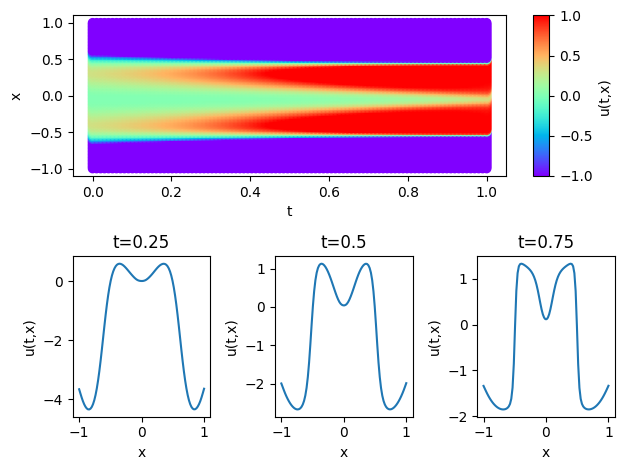

In [20]:
# visualization
epochs = config["train_epochs"]
visual(model, epochs=epochs, resolution=config["visual_resolution"])